In [1]:
# basics
import os, copy
from glob import glob
from progressbar import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# math and dates
from scipy import optimize
from scipy.signal import find_peaks
from datetime import date, datetime, timedelta

%matplotlib inline

In [2]:
# open moana dataset (30h cut-off) with skew surge on it
data = xr.open_zarr(
    '../Documents/geocean-nz-ss/data/storm_surge_data/moana_hindcast_v2/moana_coast_30h_skew_surge.zarr/')

In [3]:
data

<xarray.Dataset>
Dimensions:               (site: 1448, time: 209736)
Coordinates:
  * site                  (site) int64 0 1 2 3 4 5 ... 1443 1444 1445 1446 1447
  * time                  (time) datetime64[ns] 1994-01-17 ... 2017-12-09
Data variables:
    elev                  (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    lat                   (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon                   (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    msea                  (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    res                   (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    skew_surge_lag        (site, time) timedelta64[ns] dask.array<chunksize=(1, 104868), meta=np.ndarray>
    skew_surge_magnitude  (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    ss                    (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    tide                  (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>
    trend                 (site, time) float32 dask.array<chunksize=(1, 104868), meta=np.ndarray>

In [4]:
javi_points = np.unique( # closest Moana v2 Hindcast to tidal gauges
    sorted(
        [ 
            689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
            1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
            1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
        ]
    )
)

In [5]:
def plot_sites_comparisons(data_in, sites_id, variables_x, variables_y, 
                           variables_hue=None, ss_threshold=None):
    
    data_plot = data_in.sel(site=sites_id).load().copy()
    
    if ss_threshold:
        data_plot = data_plot.where(
            data_plot.ss>data_plot.ss.quantile(ss_threshold,dim='time')).copy()
    
    if variables_hue is None:
        variables_hue = [None]*len(variables_x)
    
    for var_x, var_y, var_hue in zip(variables_x, variables_y, variables_hue):
        
        if '+' in var_x:
            plus_pos_x = var_x.find('+')
            if '+' in var_y:
                plus_pos_y = var_y.find('+')
                data_plot = data_plot.assign({
                    var_x: data_plot[var_x[:plus_pos_x-1]]+data_plot[var_x[plus_pos_x+2:]],
                    var_y: data_plot[var_y[:plus_pos_y-1]]+data_plot[var_y[plus_pos_y+2:]]
                })
            else:
                data_plot = data_plot.assign({
                    var_x: data_plot[var_x[:plus_pos_x-1]]+data_plot[var_x[plus_pos_x+2:]]
                })
        else:
            if '+' in var_y:
                plus_pos_y = var_y.find('+')
                data_plot = data_plot.assign({
                    var_y: data_plot[var_y[:plus_pos_y-1]]+data_plot[var_y[plus_pos_y+2:]]
                })
        data_plot.plot.scatter(x=var_x,y=var_y,hue=var_hue,col='site',s=1,c='k')
        
    # plot hist of skew surge lags
    
        
    # properly make a scatter plot with ss and res + skew surge
    data_plot = data_plot.assign({
        'ss + res': data_plot['ss']+data_plot['res']
    })
    p1 = data_plot.plot.scatter(x='ss',y='skew_surge_magnitude',hue='tide',col='site',s=1)
    p2 = data_plot.plot.scatter(x='ss + res',y='skew_surge_magnitude',hue='tide',col='site',s=1)
    for ax1,ax2 in zip(p1.axes.flat,p2.axes.flat):
        ax1.plot([-0.4,0.6],[-0.4,0.6],c='k',ls='--')
        ax2.plot([-0.4,0.6],[-0.4,0.6],c='k',ls='--')

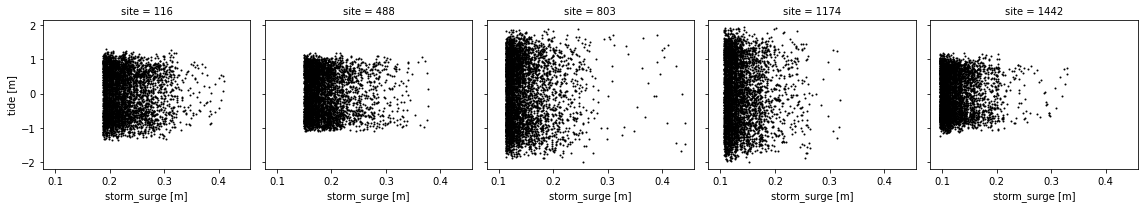

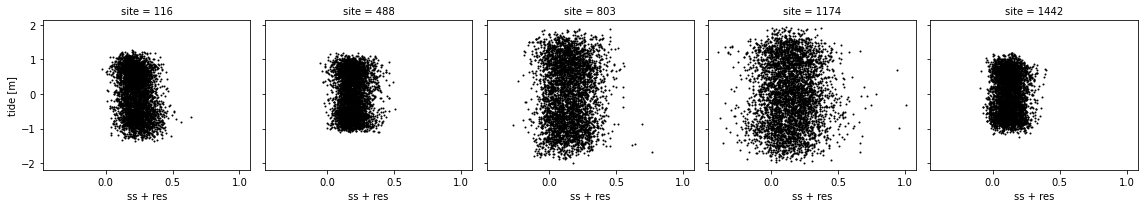

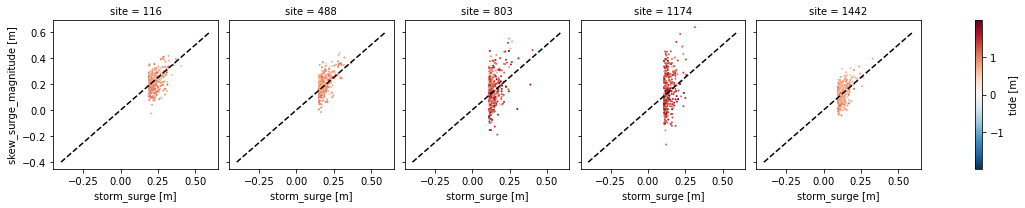

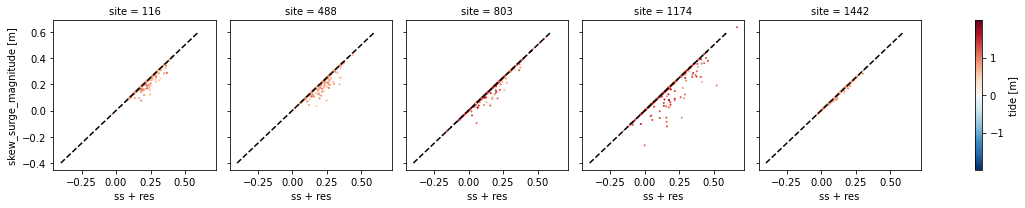

In [6]:
# plot example of function above
plot_sites_comparisons(
    data,javi_points[::7],['ss','ss + res'],['tide','tide'],ss_threshold=0.98)

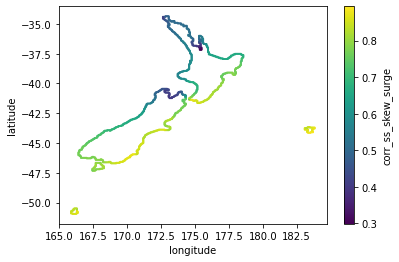

In [7]:
# here we look at the correlation between the skew surge and the storm surge
data = data.assign({
    'corr_ss_skew_surge': (('site'),xr.corr(data.ss,data.skew_surge_magnitude,dim='time').values)
})
data.plot.scatter(x='lon',y='lat',hue='corr_ss_skew_surge',s=1)

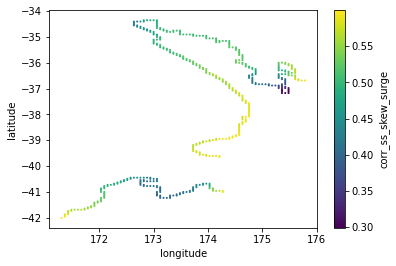

In [8]:
data.where(data.corr_ss_skew_surge<0.6).plot.scatter(x='lon',y='lat',hue='corr_ss_skew_surge',s=1)

In [9]:
bad_corr_sites = data.where(data.corr_ss_skew_surge<0.4).corr_ss_skew_surge\
    .dropna(dim='site').site.values[::10]
bad_corr_sites

array([ 706, 1174, 1195, 1219])

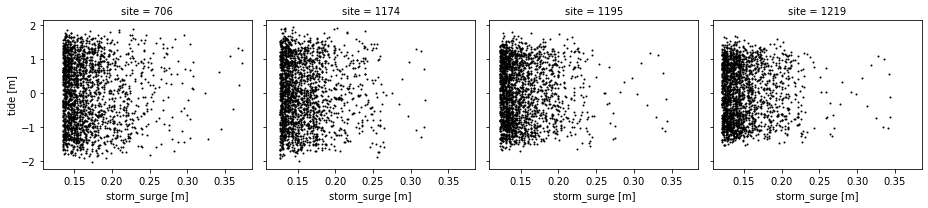

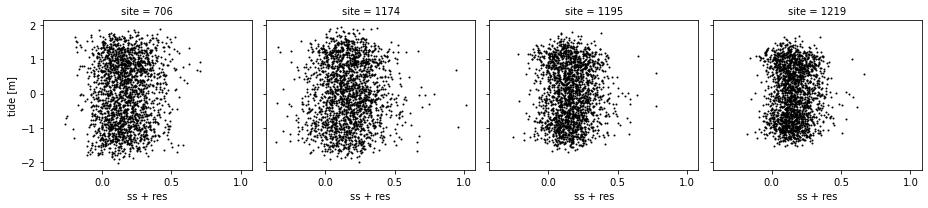

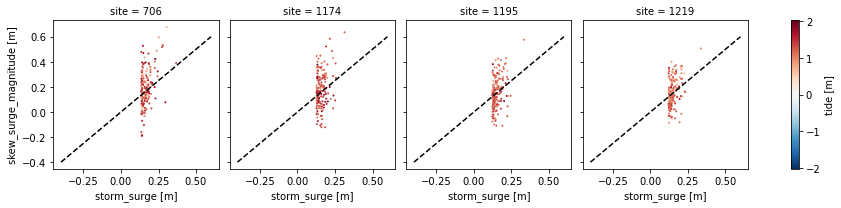

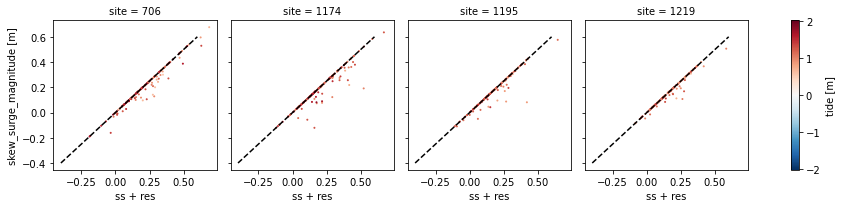

In [10]:
plot_sites_comparisons(
    data,bad_corr_sites,['ss','ss + res'],['tide','tide'],ss_threshold=0.99)

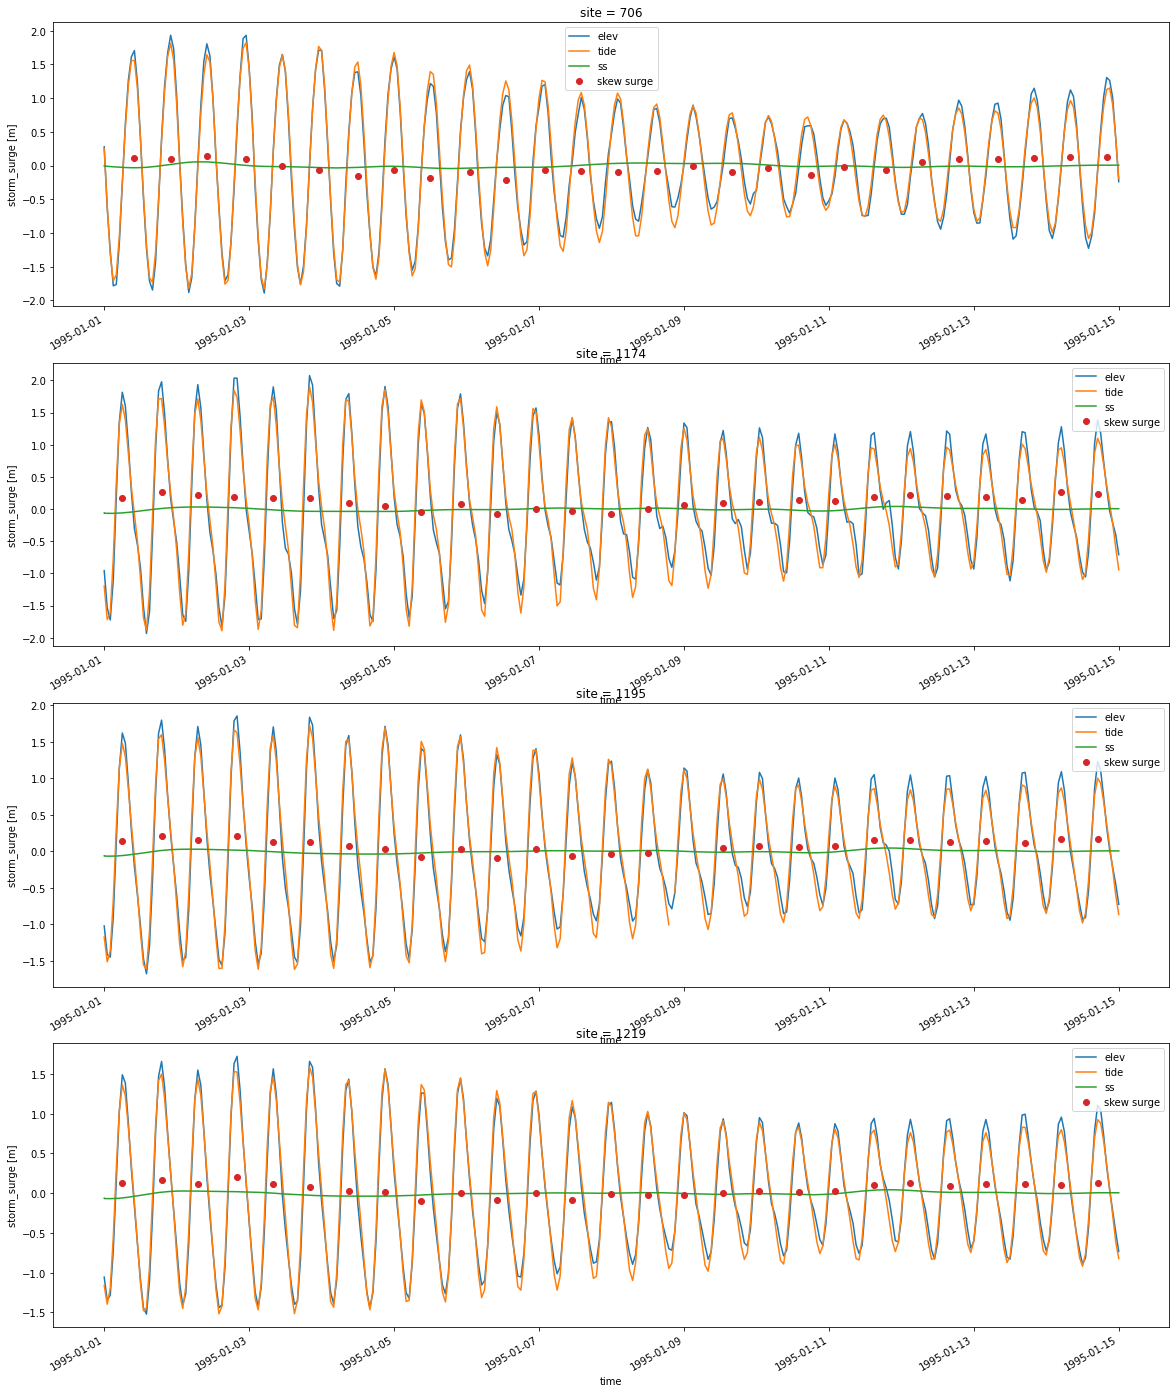

In [11]:
datasub = data.sel(site=bad_corr_sites,time=slice(datetime(1995,1,1),datetime(1995,1,15))).load()
fig, axes = plt.subplots(nrows=len(datasub.site.values),
                         figsize=(20,len(datasub.site.values)*6))
for ax,site in zip(axes,datasub.site.values):
    datasub.sel(site=site).elev.plot(ax=ax,label='elev')
    datasub.sel(site=site).tide.plot(ax=ax,label='tide')
    datasub.sel(site=site).ss.plot(ax=ax,label='ss')
    ax.plot(datasub.sel(site=site).skew_surge_magnitude.dropna(dim='time').time, 
            datasub.sel(site=site).skew_surge_magnitude.squeeze().dropna(dim='time'),'o',label='skew surge')
    ax.legend()

In [12]:
def cosine(t, amplitude, period, phase, offset):
    return amplitude*np.cos(2*np.pi*(t/period)+phase) + offset

lags = {}

for site_id in bad_corr_sites:

    site_data = data.sel(site=site_id)

    tide = site_data.tide.drop_duplicates(dim='time').squeeze().dropna(dim='time')
    elev = site_data.elev.drop_duplicates(dim='time').squeeze().dropna(dim='time')
    skew_surge = site_data.skew_surge_magnitude.drop_duplicates(dim='time')

    # Define threshold for skew surge extremes
    skew_surge_threshold = skew_surge.chunk(dict(time=-1)).quantile(0.995).values
    
    time_index = np.intersect1d(
        pd.to_datetime(tide.time).round('H'),
        pd.to_datetime(elev.time).round('H'),
        return_indices=True
    )[0]

    tide = tide.sel(time=time_index)
    elev = elev.sel(time=time_index)
    skew_surge = skew_surge.sel(time=time_index)

    lags[site_id] = {}
    lags[site_id]['lag'] = []
    lags[site_id]['pelev'] = []
    lags[site_id]['ptide'] = []
    lags[site_id]['it0'] = []
    lags[site_id]['it1'] = []

    # Find all the troughs in the tidal curves to identify tidal cycles
    troughs = find_peaks(-tide.values)[0]

    # Loop over tidal cycles
    for it0,it1 in progressbar(zip(troughs[:-1],troughs[1:])):
        
        # Extend a little the data
        it1 = min(it1+6, len(tide.values)-1)

        # Discard all cases when only nan value of skew surge are available
        if np.isnan(skew_surge[it0:it1].values).all():
            continue

        # If the skew surge in the tidal cycle is lower than threshold jump to next cycle
        if np.nanmax(skew_surge[it0:it1].values) < skew_surge_threshold:
            continue

        # If the gap between two consecutive low tides is more than a day, then jump to next cycle
        if (tide.time[it1]-tide.time[it0]).values > np.timedelta64(1,'D') or \
            (tide.time[it0]-tide.time[it1]).values > np.timedelta64(1,'D'):
            print("More than a day!")
            continue

        # Fit cosine curve to elevation data
        bounds=([elev[it0:it1].max().values-0.2, 10, 4, -0.5],
                [elev[it0:it1].max().values+0.2, 14, 8,  0.5])

        pelev, covariance = optimize.curve_fit(cosine, range(len(elev[it0:it1])),
                                               elev[it0:it1].values, bounds=bounds)

        # Fit cosine curve to tide data
        bounds=([tide[it0:it1].max().values-0.2, 10, 4, -0.5],
                [tide[it0:it1].max().values+0.2, 14, 8,  0.5])
        ptide, covariance = optimize.curve_fit(cosine, range(len(tide.time[it0:it1])),
                                               tide[it0:it1].values, bounds=bounds)

        # Store the lag divided by the tide duration
        lags[site_id]['lag'].append(pelev[1]-ptide[1])
        lags[site_id]['pelev'].append(pelev)
        lags[site_id]['ptide'].append(ptide)
        lags[site_id]['it0'].append(it0)
        lags[site_id]['it1'].append(it1)

| |                         #                     | 16825 Elapsed Time: 0:03:10
| |                             #                 | 10896 Elapsed Time: 0:02:05

KeyboardInterrupt: 

(array([ 4.,  0.,  0.,  0., 10., 72.,  0.,  0.,  0.,  1.]),
 array([-3.66502437, -2.93368456, -2.20234475, -1.47100494, -0.73966513,
        -0.00832532,  0.72301449,  1.4543543 ,  2.18569411,  2.91703392,
         3.64837373]),
 <BarContainer object of 10 artists>)

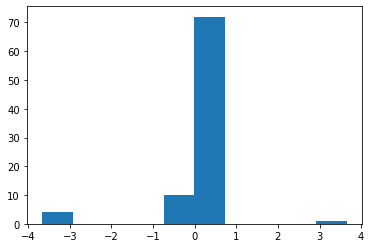

In [18]:
plt.hist(lags[706]['lag'],bins=10)